<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<hr>

# Metop-A/B GOME-2 - Tropospheric NO<sub>2</sub> - Level 2 - Pre-processing

Unfiltered Metop-A/B/C GOME-2 Level 2 data may contain negative values and measurements can further be influenced by clouds. Thus, there are some pre-processing steps required to mask the data and filter invalid ground pixels. 

This notebook shows how Metop-A/B/C GOME-2 Level 2 data can be masked, how data from Metop-A and Metop-B can be combined and how a geographical subset can be selected.

Find further information on the Metop-A/B/C GOME-2 Level 2 data in the [GOME-2 NO2 (and other trace gases) Product User Manual](https://acsaf.org/docs/pum/Product_User_Manual_NTO_OTO_DR_GDP48_Jun_2017.pdf).

#### This module has the following outline:
* [1 - Data masking](#masking)
* [2 - Combine Metop-A and Metop-B data files](#metop_ab)
* [3 - Select a geographical subset](#subset)

#### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import datetime
import glob

# Python libraries for visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

### Load multi-file `DataArray`

Let us load the ground tracks of all the measured values of MetOp-A for 1 March 2020. You can use the [load_l2_data_xr_txt](../functions.ipynb#load_l2_data_xr_txt) function to load the data as one-dimensional `xarray.DataArray`.

In [3]:
directory_2a = '../eodata/gome2/offline/2a/2020/03/01'
no2_a_da_mf = load_l2_data_xr_txt(directory=directory_2a, 
                              internal_filepath='TOTAL_COLUMNS', 
                              parameter='NO2Tropo', 
                              lat_path='GEOLOCATION/LatitudeCentre', 
                              lon_path='GEOLOCATION/LongitudeCentre', 
                              no_of_dims=1, 
                              paramname='NO2Tropo', 
                              unit='mol/cm\u00b2', 
                              longname='Tropospheric vertical column density of NO2')
no2_a_da_mf

<xarray.DataArray 'NO2Tropo' (ground_pixel: 211163)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.55 78.5 78.44 ... -84.42 -84.41 -84.39
    longitude  (ground_pixel) float32 198.8 197.0 195.2 ... 45.59 41.96 38.35
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

## <a id="masking"></a>Data masking

Metop-A/B/C GOME-2 Level 2 data provide valuable information on the quality and validity of the measured data. Different conditions can influence the measured values:
* **Negative values** can occur, which are not valid
* **Cloud fractions** influence the measured values and lead to errors, and
* **other conditions** that might make the measured data invalid, e.g. an unsuccessful fitting of the slant column.

Thus, you have to mask out the ground pixels that are invalid so that only the valid pixels remain.

### Cloud masking

Metop-A/B/C GOME-2 Level 2 data provide under the group `CLOUD_PROPERTIES` information on the `CloudFraction` for each ground pixel. The first step is to generate a cloud mask you can apply to your total column data array. As a first step, you should load the cloud fraction property with the [load_l2_data_xr_txt](../functions.ipynb#load_l2_data_xr_txt) function.

In [4]:
cloud_fraction_2a = load_l2_data_xr_txt(directory=directory_2a,
                                    internal_filepath='CLOUD_PROPERTIES', 
                                    parameter='CloudFraction', 
                                    lat_path='GEOLOCATION/LatitudeCentre', 
                                    lon_path='GEOLOCATION/LongitudeCentre', 
                                    no_of_dims=1, 
                                    paramname='CloudFraction', 
                                    unit='-', 
                                    longname='Cloud Fraction')
cloud_fraction_2a

<xarray.DataArray 'CloudFraction' (ground_pixel: 211163)>
array([0.9896364 , 0.8773051 , 0.9714895 , ..., 0.7652889 , 0.7581082 ,
       0.75459504], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 78.55 78.5 78.44 ... -84.42 -84.41 -84.39
    longitude  (ground_pixel) float32 198.8 197.0 195.2 ... 45.59 41.96 38.35
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

<br>

With xarray's function `where`, you can generate a cloud mask, by specifying e.g. each ground pixel with a `CloudFraction` higher than 50% to classify as unvalid (mask value = 0). The resulting mask has value 1 for ground pixels you want to keep and value 0 for ground pixels you want to drop. Xarray's `where` function further helps to apply the cloud mask to your `DataArray`. You want to keep the ground pixels where the cloud mask is 1 and we want to drop the rest.

The function [generate_masked_array](../functions.ipynb#generate_masked_array) combines all steps of `cloud masking`. The masked array, where negative values were filtered out, is returned. You see that the number of valid ground pixels decreased from over 200 000 to around 107 000.

In [5]:
no2_a_da_masked = generate_masked_array(no2_a_da_mf, cloud_fraction_2a, 0.5, '<', drop=True)
no2_a_da_masked

<xarray.DataArray (ground_pixel: 107769)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 79.58 79.31 79.03 ... -81.77 -82.66 -76.95
    longitude  (ground_pixel) float32 154.6 153.4 152.2 ... 86.27 92.45 68.4
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

<br>

Let us visualize the masked data array with the function [visualize_scatter](../functions.ipynb#visualize_scatter) using the `Mollweide` projection. Filtering out the pixels with a high cloud fraction however is just one part. Another important part is to remove all negative values. We multiply the data with a conversion factor of `1e-15` for better legibility of the plot scale.

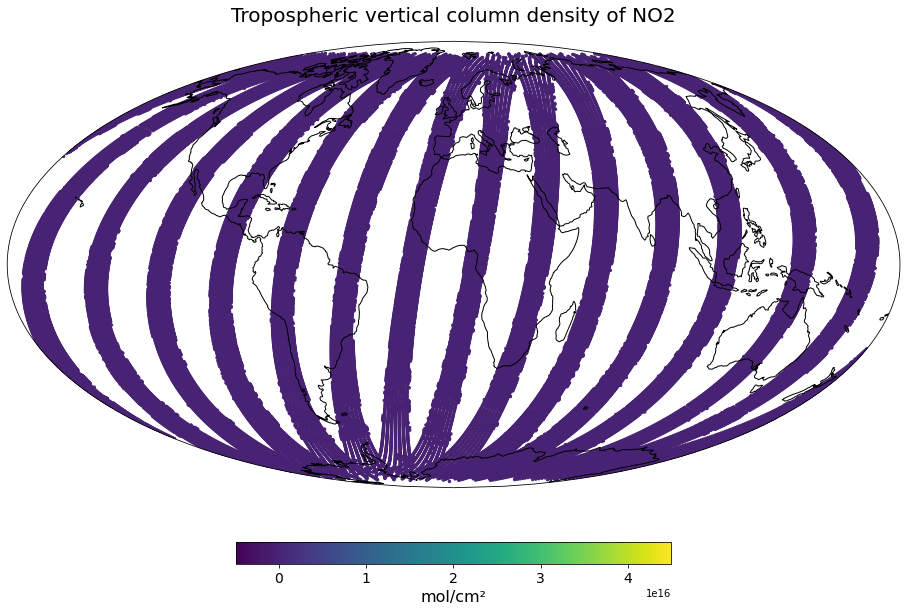

In [6]:
visualize_scatter(xr_dataarray=no2_a_da_masked, 
             conversion_factor=1e-15,
             projection=ccrs.Mollweide(), 
             vmin=no2_a_da_masked.min(), 
             vmax=no2_a_da_masked.max(), 
             point_size=6, 
             color_scale='viridis', 
             unit=no2_a_da_masked.units, 
             title=no2_a_da_masked.long_name)

<br>

### Flag negative values

Negative values can be flagged by casting the `xarray.DataArray` for only positive values. The number of ground pixels in the resulting data array decreased from around 107,000 to around 43,000 values.

In [7]:
no2_a_da_mf_flagged = no2_a_da_masked[no2_a_da_masked > 0]

no2_a_da_mf_flagged

<xarray.DataArray (ground_pixel: 43343)>
array([2.35977478e+13, 1.51699906e+14, 1.08658076e+14, ...,
       1.46247797e+14, 2.74446598e+14, 7.16572008e+13], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.77 69.89 69.2 ... -68.11 -69.66 -69.97
    longitude  (ground_pixel) float32 150.8 146.8 149.6 ... 106.2 107.5 106.9
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

<br>

When comparing the minimum values of the original data array and the flagged data array, you see that the minimum is not negative anymore. 

In [8]:
print(no2_a_da_masked.min(), no2_a_da_mf_flagged.min())

<xarray.DataArray ()>
array(-4.8604325e+15, dtype=float32) <xarray.DataArray ()>
array(3.3558553e+10, dtype=float32)


Visualizing the `xarray.DataArray` shows a more detailed representation of the total column NO<sub>2</sub>. We multiply the data with a conversion factor of `1e-15` for better legibility of the plot scale.

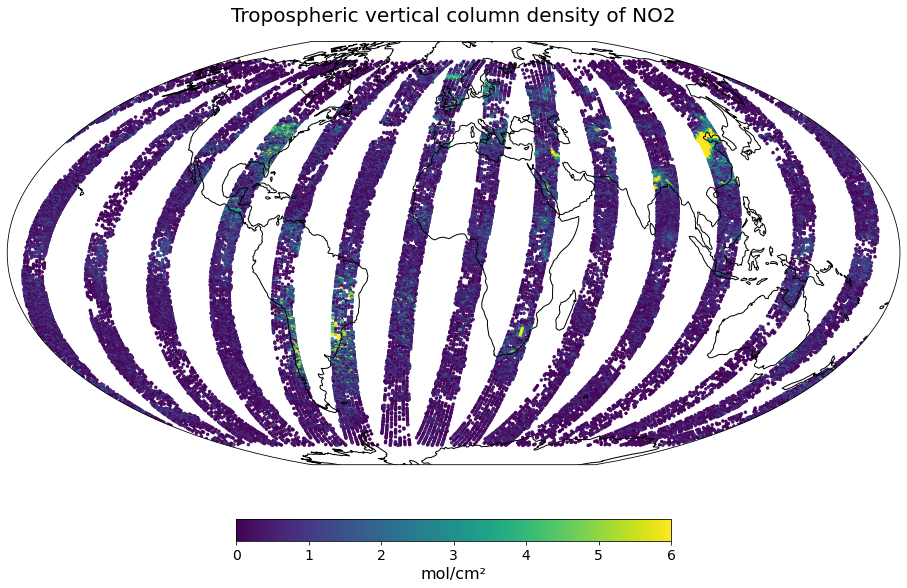

In [9]:
visualize_scatter(xr_dataarray=no2_a_da_mf_flagged, 
             conversion_factor=1e-15,
             projection=ccrs.Mollweide(), 
             vmin=0, 
             vmax=6, 
             point_size=6, 
             color_scale='viridis', 
             unit=no2_a_da_mf_flagged.units, 
             title=no2_a_da_mf_flagged.long_name)

<br>

## <a id="metop_ab"></a>Combine Metop-A and Metop-B GOME-2 Level 2 data files

The above example shows that Metop-A data have many parts on Earth unsensed. Metop-A data can be combined with Metop-B ground pixels for one specific day to increase the overall coverage. Metop-B has a wider nominal resolution than Metop-A.

Since you already concatenated and filtered the ground pixel values for day 1 March 2020 for Metop-A GOME-2 Level 2 data, you only have to repeat the same pre-processing steps for the Metop-B data files:

1. Load total column of tropospheric NO<sub>2</sub> values with the function [load_l2_data_xr](../functions.ipynb#load_l2_data_xr)
2. Load cloud fraction information with the function [load_l2_data_xr](../functions.ipynb#load_l2_data_xr)
3. Filter ground pixels with too much cloud coverage with the function [generate_masked_array](../functions.ipynb#generate_masked_array)
4. Flag out negative values
4. Visualize the masked and flagged array with the function [visualize_scatter](../functions.ipynb#visualize_scatter).

#### 1. Load total column NO<sub>2</sub> values from MetOp-B GOME-2 Level 2 files

In [10]:
directory_2b= '../eodata/gome2/offline/2b/2020/03/01'
no2_b_da_mf = load_l2_data_xr_txt(directory=directory_2b,
                              internal_filepath='TOTAL_COLUMNS', 
                              parameter='NO2Tropo', 
                              lat_path='GEOLOCATION/LatitudeCentre', 
                              lon_path='GEOLOCATION/LongitudeCentre', 
                              no_of_dims=1, 
                              paramname='NO2Tropo', 
                              unit='mol/cm\u00b2', 
                              longname='Tropospheric vertical column density of NO2')
no2_b_da_mf

<xarray.DataArray 'NO2Tropo' (ground_pixel: 209865)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 75.53 75.48 75.43 ... -86.62 -86.41 -86.19
    longitude  (ground_pixel) float32 165.7 164.3 162.9 ... 28.03 23.34 19.14
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

#### 2. Load cloud fraction information

In [11]:
cloud_fraction_2b = load_l2_data_xr_txt(directory=directory_2b,
                                    internal_filepath='CLOUD_PROPERTIES',
                                    parameter='CloudFraction', 
                                    lat_path='GEOLOCATION/LatitudeCentre', 
                                    lon_path='GEOLOCATION/LongitudeCentre', 
                                    no_of_dims=1, 
                                    paramname='CloudFraction',
                                    unit='-', 
                                    longname='Cloud Fraction') 
cloud_fraction_2b

<xarray.DataArray 'CloudFraction' (ground_pixel: 209865)>
array([0.98337656, 0.96765983, 0.92491144, ..., 0.67418593, 0.7164886 ,
       0.75304663], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 75.53 75.48 75.43 ... -86.62 -86.41 -86.19
    longitude  (ground_pixel) float32 165.7 164.3 162.9 ... 28.03 23.34 19.14
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Cloud Fraction
    units:      -

#### 3. Mask data array

In [12]:
no2_b_da_masked = generate_masked_array(no2_b_da_mf, cloud_fraction_2b, 0.5, '<', drop=True)
no2_b_da_masked

<xarray.DataArray (ground_pixel: 112439)>
array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 77.72 79.15 76.33 ... -85.52 -82.64 -85.86
    longitude  (ground_pixel) float32 117.5 105.1 122.7 ... 83.88 73.53 60.79
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

#### 4. Flag out negative values

In [13]:
no2_b_da_mf_flagged = no2_b_da_masked[no2_b_da_masked > 0]

no2_b_da_mf_flagged

<xarray.DataArray (ground_pixel: 45175)>
array([2.78295594e+13, 1.55059661e+14, 5.17116422e+12, ...,
       1.05479171e+14, 1.22471395e+14, 9.63108919e+13], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.02 69.99 69.51 ... -68.31 -69.75 -68.57
    longitude  (ground_pixel) float32 132.8 127.8 126.3 ... 112.8 117.8 112.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

#### 5. Visualization of masked Metop-B GOME-2 Total column NO<sub>2</sub> ground pixels

We multiply the data with a conversion factor of `1e-15` for better legibility of the plot scale.

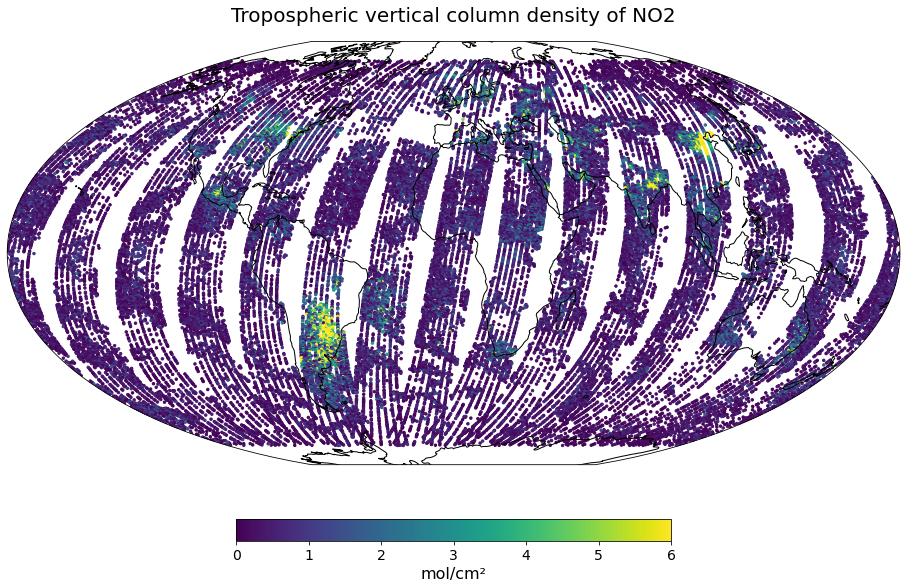

In [14]:
visualize_scatter(xr_dataarray=no2_b_da_mf_flagged, 
             conversion_factor=1e-15,
             projection=ccrs.Mollweide(), 
             vmin=0, 
             vmax=6, 
             point_size=6, 
             color_scale='viridis', 
             unit=no2_b_da_mf_flagged.units, 
             title=no2_b_da_mf_flagged.long_name)

<br>

### Combine masked `xarray.DataArrays` with `xarray.concat`

To combine data from Metop-A and Metop-B, you have to concatenate both `xarray.DataArrays` with `xarray.concat`. The resulting `xarray.DataArray` object has more than 88,500 ground pixel values. With the function [visualize_scatter](../functions.ipynb#visualize_scatter), you can visualize the combined `xarrray.DataArray`.

In [15]:
no2_ab_da_masked = xr.concat([no2_a_da_mf_flagged, no2_b_da_mf_flagged], dim='ground_pixel')
no2_ab_da_masked

<xarray.DataArray (ground_pixel: 88518)>
array([2.35977478e+13, 1.51699906e+14, 1.08658076e+14, ...,
       1.05479171e+14, 1.22471395e+14, 9.63108919e+13], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.77 69.89 69.2 ... -68.31 -69.75 -68.57
    longitude  (ground_pixel) float32 150.8 146.8 149.6 ... 112.8 117.8 112.2
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

We multiply the data with a conversion factor of `1e-15` for better legibility of the plot scale.

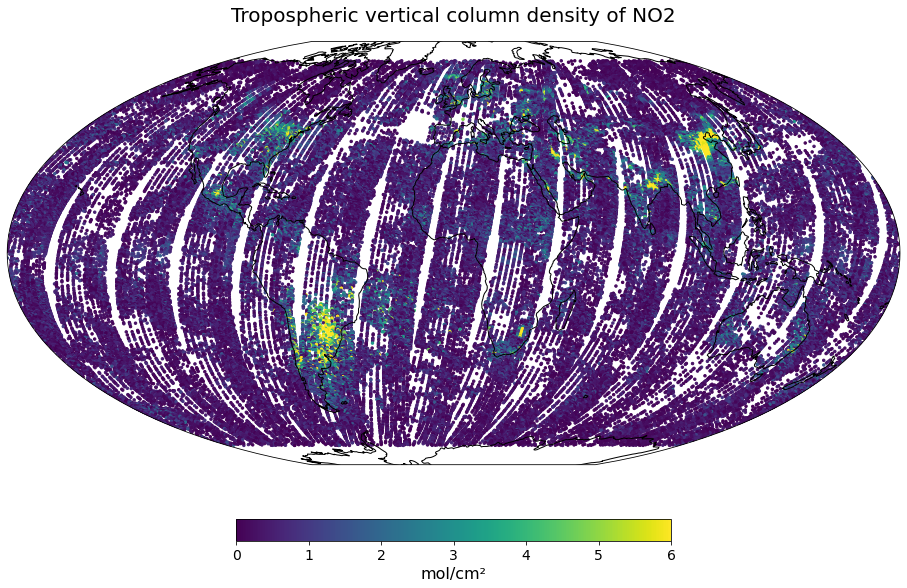

In [16]:
visualize_scatter(xr_dataarray=no2_ab_da_masked, 
             conversion_factor=1e-15,
             projection=ccrs.Mollweide(), 
             vmin=0, 
             vmax=6, 
             point_size=6, 
             color_scale='viridis', 
             unit=no2_ab_da_masked.units, 
             title=no2_ab_da_masked.long_name)

<br>

## <a id="subset"></a>Select geographical subset

You can generate a `geographical subset` of the `DataArray` to get a closer look at one specific region. The subset can easily be created with xarray's function `where`. We can assign for `latitude` and `longitude` a minimum and maximum threshold. By using the `drop` argument, we drop the data values for which the condition is False.

There is one caveat: the `longitude` values of the Metop-A/B/C GOME-2 Level 2 data are stored as 0 to 360-degrees longitudes. Thus, if you want to select the geographical subset based on a geographical bounding box of -180 to 180 degrees, you have to convert the `longitude` values first. This is done by assigning `longitude` values with the `assign_coords` function.

In [17]:
no2_ab_da_masked = no2_ab_da_masked.assign_coords(longitude=(((no2_ab_da_masked.longitude + 180) % 360) - 180))

#### Select the bounding box with xarray's `where` function

Let us select a bounding box over South America and parts of Central and Southern Africa with the following latitude and longitude boundaries:
* `latitude`: -60 deg to 15 deg
* `longitude`: -80 deg to 40 deg

In [18]:
no2_ab_da_subset = no2_ab_da_masked.where((no2_ab_da_masked.latitude < 15) & 
                                          (no2_ab_da_masked.latitude > -60) &
                                          (no2_ab_da_masked.longitude < 40) & 
                                          (no2_ab_da_masked.longitude > -80),
                                          drop=True)
no2_ab_da_subset

<xarray.DataArray (ground_pixel: 17810)>
array([3.95165882e+14, 1.12530475e+14, 4.03645347e+13, ...,
       6.70980729e+14, 3.36122731e+14, 4.73359821e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 -50.23 -50.57 -50.91 ... -53.34 -54.03
    longitude  (ground_pixel) float32 39.35 39.15 38.95 ... -79.27 -79.5 -79.65
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Tropospheric vertical column density of NO2
    units:      mol/cm²

<br>

You can now visualize the geographic subset with the defined function [visualize_scatter](../functions.ipynb#visualize_scatter) and represent the subset in a `PlateCarree` projection. We multiply the data with a conversion factor of `1e-15` for better legibility of the plot scale.

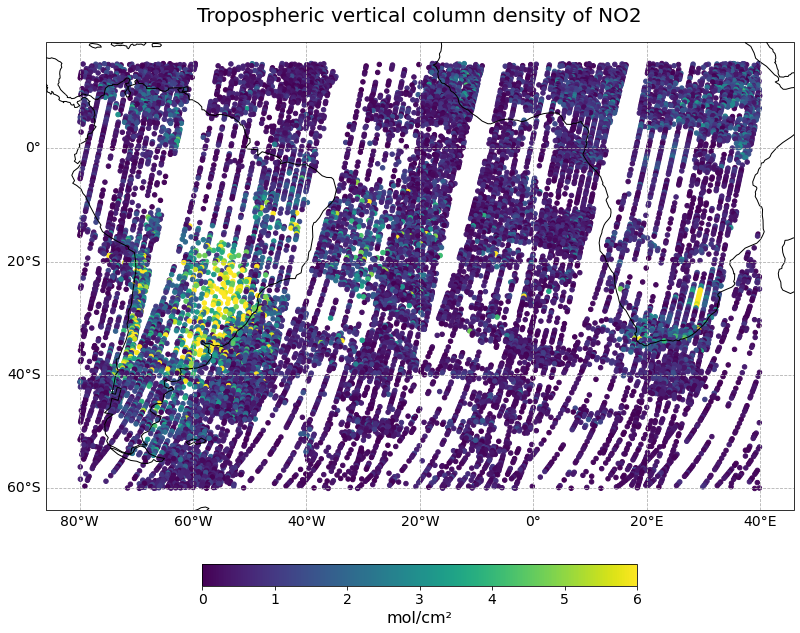

In [19]:
visualize_scatter(xr_dataarray=no2_ab_da_subset, 
                  conversion_factor=1e-15, 
                  projection=ccrs.PlateCarree(), 
                  vmin=0,
                  vmax=6, 
                  point_size=20,
                  color_scale='viridis', 
                  unit=no2_ab_da_subset.units, 
                  title=no2_ab_da_subset.long_name)

<br>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>